In [ ]:
!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Step 1 - Obtain tickers of SPY, (the chosen etf) and place them in a list
state_street = list(pd.read_excel("https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx", header=4).dropna().Ticker)
blackrock = list(pd.read_csv("https://www.blackrock.com/us/individual/products/239726/ishares-core-sp-500-etf/1464253357814.ajax?fileType=csv&fileName=IVV_holdings&dataType=fund", header = 9).Ticker.dropna())

tickers = list(set(state_street) & set(blackrock))

In [ ]:
# step 2 -> Obtain the data metrics we need being adj close + Volume + returns from yahoo finance
data = yf.download(tickers, period='7y')[["Adj Close", "Volume"]]
data = data.dropna(how="all", axis=1)
close = data['Adj Close']
volume = data['Volume']
returns = data['Adj Close'].pct_change().resample("M").sum().shift(-1)



[*********************100%***********************]  500 of 500 completed


In [ ]:
# step 3 -> Calculating price momentum factor scores 

class Momentum_Factors():
  def __init__(self, stock_data, tickers):
    self.price = close
    self.volume = volume
    self.returns = returns
    self.tickers = tickers

    self.mom_factors_df = pd.DataFrame(index = self.tickers)

# Calculates the 52 week price trend line  
  def fifty_two_trend_line(self):
    self.fifty_two_trend_line_df = pd.DataFrame(index=self.tickers)

    for i in range(1, 21):
          self.fifty_two_trend_line_df[i] = np.polyfit(range(len(self.price[-i - 252 : -i])), self.price[-i -252 : -i], 1)[0]
    return self.fifty_two_trend_line_df.mean(axis=1)


  def factors(self):

# Gives the percent increase from 252 day low
        self.roll_min = self.price.rolling(252).min()
        self.mom_factors_df["pct_above"] = ((self.price - self.roll_min) / self.roll_min)[-20:].mean()

# Gives the momentum factor of price oscillator
        self.mom_factors_df["price_oscillator"] = ((self.price.rolling(20).mean() - self.price.rolling(260).mean())
          /self.price.rolling(260).std())[-20:].mean()

# Gives the 39 week return momentum factor
        self.mom_factors_df["39_wk_ret"] = self.price.pct_change(189)[-20:].mean()
        
# Gives the 51 week volume momentum factor
        self.mom_factors_df["price_volume"] = (
            (self.returns * self.volume).rolling(252).sum()[-20:].mean())
        
# Places the 52 week trend into mom_factors_df         
        self.mom_factors_df["fifty_two_trend_line"] = self.fifty_two_trend_line()

        return self.mom_factors_df

## Step 4 -> Aggregating the factor scores using z-score
  def aggregate(self):
      self.mom_factors_df = self.factors()
      self.scored = ((self.mom_factors_df - self.mom_factors_df.mean()) / self.mom_factors_df.std()).sum(axis=1)
      return self.scored

## step 5 -> Ranking the stocks
  def baskets(self):
      self.z_scored = self.aggregate()
      return self.z_scored.nlargest(10).index, self.z_scored.nsmallest(10).index


In [ ]:
# Step 6 -> 5 year backtest to validate the trading algorithm 
dates_range = pd.DataFrame(pd.date_range("2017-12-18", dt.datetime.today(), freq="M"))
dates_range.rename(columns={0: "date"}, inplace=True)
long_returns, short_returns = pd.DataFrame(), pd.DataFrame()


for date in dates_range.date:
  MF = Momentum_Factors(data[data.index <= date], tickers)
  longs, short = MF.baskets()
  
  long_returns = long_returns.append(returns[longs].loc[date])
  short_returns = short_returns.append(returns[short].loc[date])

In [ ]:
long_returns.iloc[-1].dropna()

ENPH   -0.046497
OXY    -0.101937
EQT    -0.124717
XOM    -0.060144
APA    -0.063133
MPC    -0.101345
HES    -0.073407
VLO    -0.108636
WAB    -0.016744
SLB    -0.034990
Name: 2022-11-30 00:00:00, dtype: float64

In [ ]:
# Step 7 -> Plotting the selected stocks and comparing them to the S&P 500

sum_returns = pd.DataFrame(long_returns.mean(axis=1) - short_returns.mean(axis=1)).shift()
sum_returns = sum_returns[-60:]

sum_returns["cum_ret"] = np.exp(np.log1p(sum_returns).cumsum())

sum_returns["SPY"] = (
    yf.download("SPY", period="7y")["Adj Close"].pct_change().resample("M").sum()
)


[*********************100%***********************]  1 of 1 completed


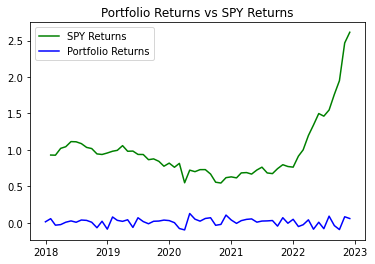

In [ ]:
# Plotting a Line Graph Comparing the Portfolio Returns vs the ETF SPY Returns

plt.plot(sum_returns["cum_ret"],
         label="SPY Returns",
        color="g")

plt.plot(sum_returns["SPY"],
         label="Portfolio Returns",
        color="b")

plt.legend()
plt.title('Portfolio Returns vs SPY Returns');

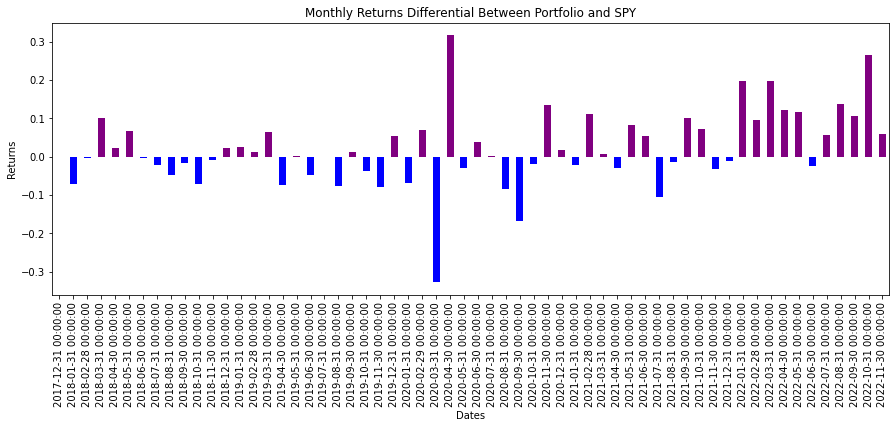

In [ ]:
# Plotting the Monthly Return Differential Between Our Portfolio Returns & Spy

sum_returns['colors'] = (sum_returns[0] > 0)   
                                                
sum_returns[0].plot(kind='bar'
                   , figsize=(15,5)
                   , title='Monthly Returns Differential Between Portfolio and SPY'
                   , xlabel='Dates'
                   , ylabel='Returns'
                   , color=['purple' if i == True else 'blue' for i in sum_returns['colors']]);
                   

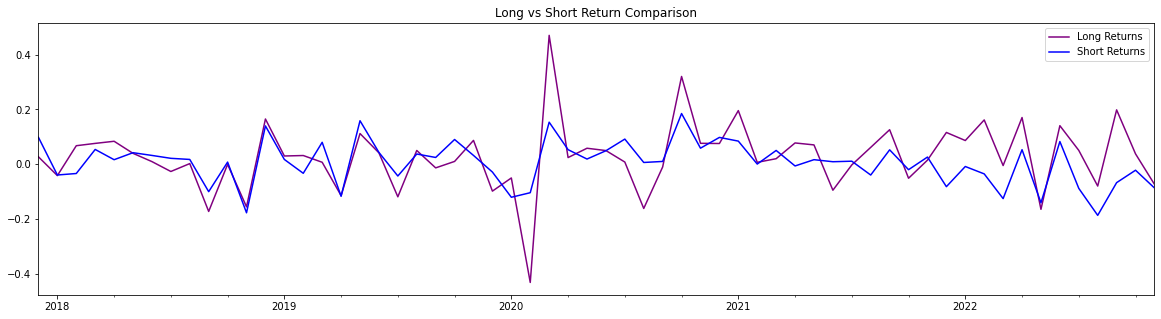

In [ ]:
# Plotting the Long vs Short Returns

fig = plt.subplots(figsize=(20,5))
plt.title('Long vs Short Return Comparison');
long_returns.mean(axis=1).plot(
    color="purple",
    label="Long Returns"
)
short_returns.mean(axis=1).plot(
    color="blue",
    label="Short Returns"
)
plt.legend()
plt.show()

In [ ]:
# Credit
# Credit to professor John Droescher's code
#
#